In [6]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import joypy
import requests
import json

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


import tracemalloc
import time
import yellowbrick
from yellowbrick.regressor import ResidualsPlot, CooksDistance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot

import lime 
from lime import lime_tabular
import shap
shap.initjs()
import re

import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('df_HDB.csv')
y = df[['resale_price']]
X = df.drop(['resale_price','town', 'year'], axis=1)

In [8]:
def tracing_start():
    tracemalloc.stop()
    print("nTracing Status : ", tracemalloc.is_tracing())
    tracemalloc.start()
    print("Tracing Status : ", tracemalloc.is_tracing())
def tracing_mem():
    first_size, first_peak = tracemalloc.get_traced_memory()
    peak = first_peak/(1024*1024)
    print("Peak Size in MB - ", peak)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, shuffle=True, random_state=0)

param_grid = {
    'max_features': ['auto'], # max number of features considered for splitting a node
    'max_depth': [20], # max number of levels in each decision tree
    'min_samples_split': [15], # min number of data points placed in a node before the node is split
    'min_samples_leaf': [2]} # min number of data points allowed in a leaf node
rfr =HalvingGridSearchCV(RandomForestRegressor(n_estimators = 500, n_jobs=-1, random_state=0),
                        param_grid, cv=5, scoring='r2', return_train_score=True, min_resources='smallest')
tracing_start()
start = time.time()

#Fitting model
rfr.fit(X_train,y_train.values.ravel())

#Validating on best parameters on grid search
print("Best parameters set found on Cross Validation:\n\n", rfr.best_params_)
print("\nCross Validation R\u00b2 score:\n\n", rfr.best_score_.round(3))
end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

tracing_start()
start = time.time()
# predict and get evaluation metrics for test set
cv_predicted_test = rfr.predict(X_test)

cv_test_score = r2_score(y_test['resale_price'], cv_predicted_test)
cv_mae = mean_absolute_error(y_test['resale_price'], cv_predicted_test)
cv_mse = mean_squared_error(y_test['resale_price'], cv_predicted_test)
cv_rmse = np.sqrt(mean_squared_error(y_test['resale_price'], cv_predicted_test))

# Display result with test set 
print(f'Test data R\u00b2 score: {cv_test_score}')
print(f'Test data Mean Absolute Error: {round(cv_mae)}')
print(f'Test data Mean Squared Error: {round(cv_mse)}')
print(f'Test data Root Mean Squared Absolute Error: {round(cv_rmse)}')
end = time.time()
print("time elapsed {} milli seconds".format((end-start)*1000))
tracing_mem()

nTracing Status :  False
Tracing Status :  True
Best parameters set found on Cross Validation:

 {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 15}

Cross Validation R² score:

 nan
time elapsed 84645.47395706177 milli seconds
Peak Size in MB -  33.87488842010498
nTracing Status :  False
Tracing Status :  True
Test data R² score: 0.9654692904625685
Test data Mean Absolute Error: 20516
Test data Mean Squared Error: 763767638
Test data Root Mean Squared Absolute Error: 27636
time elapsed 328.6101818084717 milli seconds
Peak Size in MB -  3.8533248901367188


Text(0.5, 1.0, 'RandomForest CV')

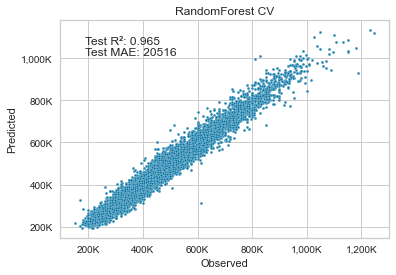

In [15]:
fig = plt.figure(figsize=(13,4))

# Visual comparison between Grid and non-grid use
ax1 = plt.subplot(121)
ax1 = sns.scatterplot(x=y_test['resale_price'], y=cv_predicted_test, edgecolors='w', alpha=0.9, s=8)
ax1.set_xlabel('Observed'), ax1.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in ax1.get_xticks()/1000])
ax1.set_ylabel('Predicted'), ax1.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in ax1.get_yticks()/1000])
ax1.annotate('Test R\u00b2: ' + str(round(cv_test_score,3)) + '\nTest MAE: ' + str(round(cv_mae)), xy=(0, 1), xytext=(25, -35),
    xycoords='axes fraction', textcoords='offset points', fontsize=12)
ax1.set_title('RandomForest CV')

In [16]:
# Produce a matrix for client data
client_data = [[1, 3, 68, 1986, 0.594128259344289, 15 ,0.22516102677612, 8 ,0.376763931855833,28, 1.5803380574408, 1, 1.1060523511997, 2, 0.274218362591398, 9, 9.26348665949998, 0,0,1,0,0,0,1,0,0], # Client 1
               [2, 2, 93, 2010, 0.173394270589029, 20 ,0.495748156781795, 1 ,0.801641910325716,3, 1.2895891636303, 1, 0.354436984819771, 23, 0.0441655994955788, 17, 13.6128567065317, 0,0,1,0,1,0,0,0,0], # Client 2
               [2, 0, 112, 1995, 0.18934288586454, 17 ,2.03316923897357, 0 ,0.466650001317567,11, 0.398785707885446, 6, 0.97903269235057, 6, 0.413983861488505, 16, 13.782717157755, 1,0,0,0,0,0,1,0,0]]  # Client 3
print('Resale price: $255,000.00, $440,000.00, $385,000.00')
print('Adj. inflation: $268,429.53, $463,172.52, $403,720.52')
# Show predictions
for i, price in enumerate(rfr.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)) 

Resale price: $255,000.00, $440,000.00, $385,000.00
Adj. inflation: $268,429.53, $463,172.52, $403,720.52
Predicted selling price for Client 1's home: $289,270.50
Predicted selling price for Client 2's home: $472,032.59
Predicted selling price for Client 3's home: $399,607.79
